# Exploring Spotify Daily Top 200 Charts for 2022

Data for 50 regions (global and 49 countries) was scraped from the Spotify Charts website using the `download_charts.py` and `combine_charts.py` scripts (they can be found in the `cli-scripts` folder).

In [1]:
import pandas as pd
from helpers.data import create_data_path

In [2]:
charts = pd.read_parquet(create_data_path('top200_2022.parquet'))

In [3]:
charts

,date,region_code,track_id,pos,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams
0,2022-01-01,ae,5PjdY0CKGZdEuoNab3yDmX,1,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),Columbia,1,1,177,8656
1,2022-01-01,ae,5Z9KJZvQzH6PFmb8SNkxuk,2,"Lil Nas X, Jack Harlow",INDUSTRY BABY (feat. Jack Harlow),Columbia,2,4,163,7871
2,2022-01-01,ae,02MWAaffLxlfxAUY7c5dvx,3,Glass Animals,Heat Waves,Polydor Records,2,3,389,7743
3,2022-01-01,ae,2Xr1dTzJee307rmrkt8c0g,4,CKay,love nwantiti (ah ah ah),Chocolate City Music,2,5,116,7239
4,2022-01-01,ae,1r9xUipOqoNwggBpENDsvJ,5,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,KIDinaKORNER/Interscope Records,5,9,60,7065
...,...,...,...,...,...,...,...,...,...,...,...
5098013,2022-12-31,za,7IQbOBVEQTb3lGNNi1e71i,196,"Focalistic, Mellow & Sleazy, M.J, Pabi Cooper",Tsela Tse Nyane,18 Area Holdings,21,102,44,7673
5098014,2022-12-31,za,1JSTJqkT5qHq8MDJnJbRE1,197,The Police,Every Breath You Take,Polydor Records,56,-1,81,7662
5098015,2022-12-31,za,39sSsu4g7vjVOax8DU98NX,198,"Kabza De Small, Nkosazana Daughter, Murumba Pitch",Isoka (feat. Nkosazana Daughter & Murumba Pitch),Piano Hub,21,-1,103,7651
5098016,2022-12-31,za,2GAhgAjOhEmItWLfgisyOn,199,SZA,Low,Top Dawg Entertainment/RCA Records,22,85,21,7641


In [4]:
regions = charts.groupby('region_code').size().sort_values(ascending=False)
regions

region_code
jp    73000
pe    73000
hn    73000
hu    73000
ie    73000
      ...  
ve    55800
pk    45006
ee    39477
is    34222
lu    15562
Length: 73, dtype: int64

<Axes: xlabel='region_code'>

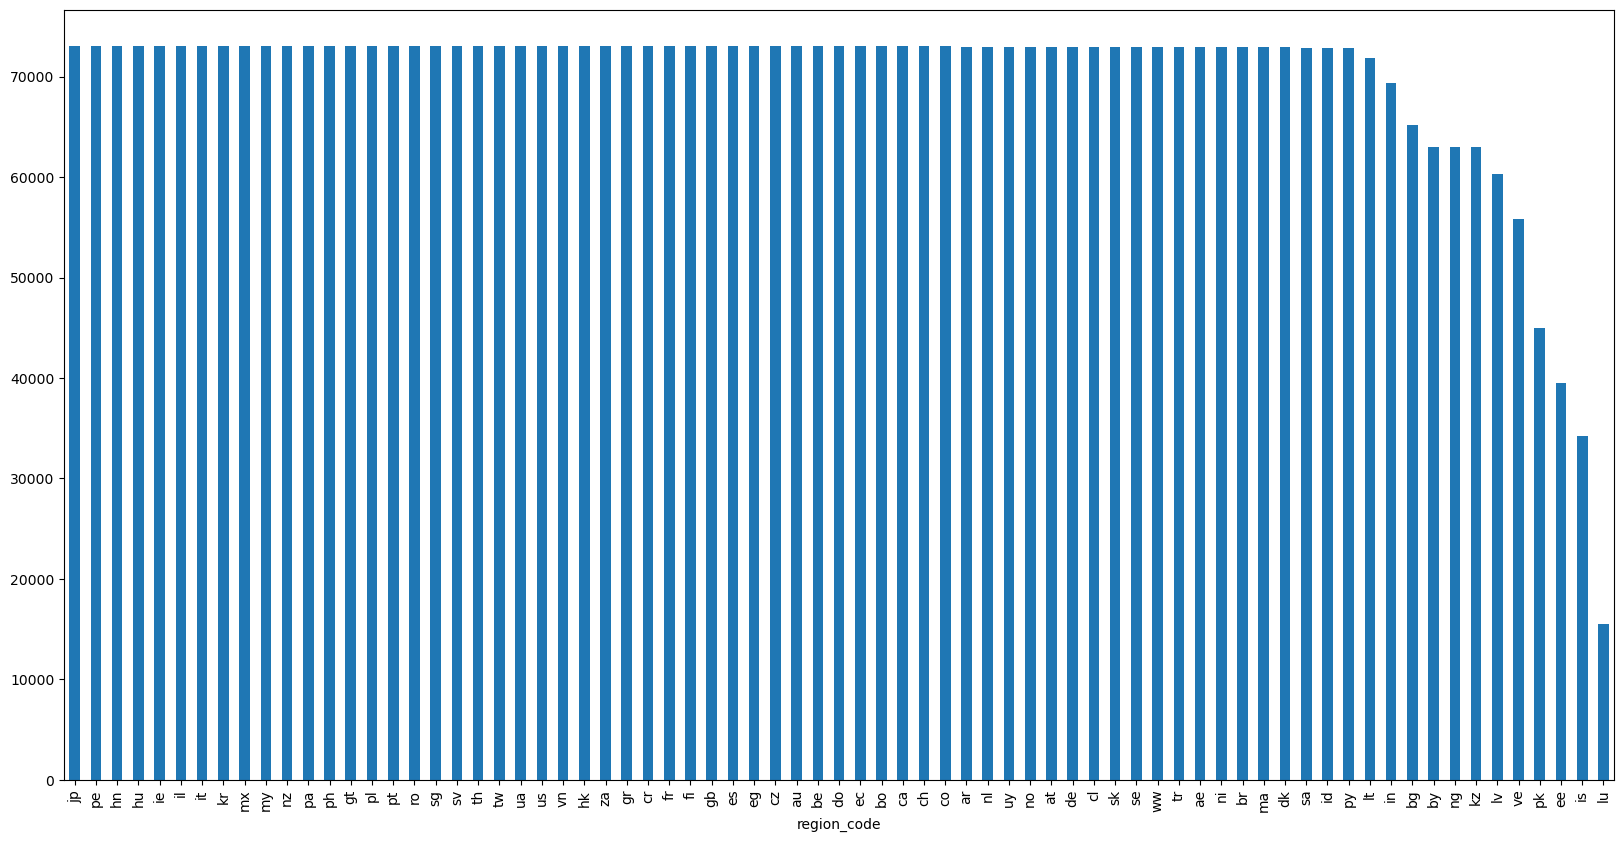

In [22]:
from matplotlib import pyplot as plt
regions.plot.bar(figsize=(20, 10))

Looks like data completeness is good for most of the countries :)

In [34]:
complete_data_chart_entry_count = 365 * 200
complete_data_chart_entry_count

73000

In [37]:
regions[regions / 73000 < 0.99]

region_code
lt    71811
in    69382
bg    65157
by    63000
ng    63000
kz    62957
lv    60291
ve    55800
pk    45006
ee    39477
is    34222
lu    15562
dtype: int64

In [38]:
len(regions[regions / 73000 < 0.99])

12

We notice that only for 12 countries the data is less than 99% complete.

## Identifying biggest markets

We will just group the chart entries by country and sum up the streams.

### Biggest markets by number of streams for 2022

A simple approach is just summing up the number of streams for each country. This approach gives us a good idea for the absolute number of streams of the Top 200 for all countries where we have (almost) complete data (i.e. (almost) no tracks missing in the Top 200 for each day).

<Axes: title={'center': 'Top 20 countries by streams'}, xlabel='region_code'>

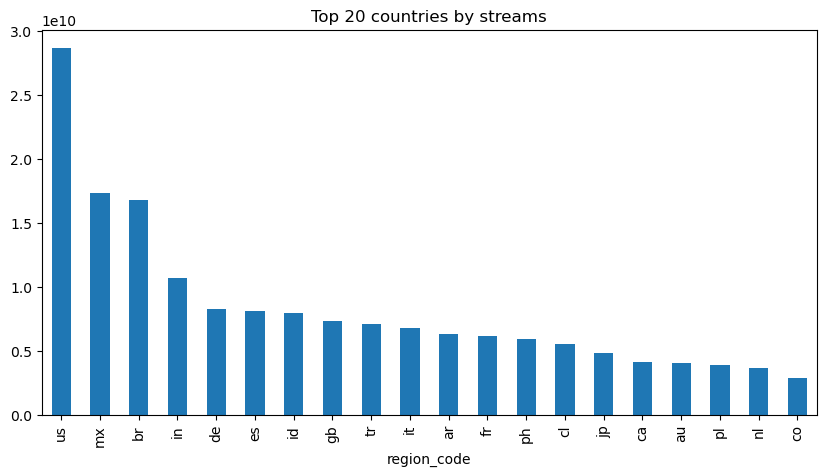

In [5]:
streams_by_region = charts.groupby('region_code').streams.sum()
streams_by_country = streams_by_region[streams_by_region.index != 'ww'].sort_values(ascending=False)
top_k = 20
top_k_plt = streams_by_country.sort_values(ascending=False)[:top_k].plot
top_k_plt(kind='bar', figsize=(10, 5), title=f'Top {top_k} countries by streams')

### Biggest markets in relation to country population

probably it is smarter to identify "important" markets by putting the number of total streams in relation to the total population of each country. Unfortunately, no data is available for 2022 yet (as of June 21st, 2023). So, I use the data from the year 2021.

In [6]:
population = pd.read_csv(create_data_path('country_population.csv'), skiprows=3)[['Country Code', '2021']].rename(columns={'Country Code': 'alpha3', '2021': 'population'})
population

,alpha3,population
0,ABW,106537.0
1,AFE,702976832.0
2,AFG,40099462.0
3,AFW,478185907.0
4,AGO,34503774.0
...,...,...
261,XKX,1786038.0
262,YEM,32981641.0
263,ZAF,59392255.0
264,ZMB,19473125.0


In [7]:
country_codes = pd.read_csv(create_data_path('country_codes.csv'))[['alpha-3', 'alpha-2']].rename(columns={'alpha-3': 'alpha3', 'alpha-2': 'alpha2'})
country_codes

,alpha3,alpha2
0,AFG,AF
1,ALA,AX
2,ALB,AL
3,DZA,DZ
4,ASM,AS
...,...,...
244,WLF,WF
245,ESH,EH
246,YEM,YE
247,ZMB,ZM


In [8]:
country_population = pd.merge(country_codes, population, on='alpha3')
country_population

,alpha3,alpha2,population
0,AFG,AF,40099462.0
1,ALB,AL,2811666.0
2,DZA,DZ,44177969.0
3,ASM,AS,45035.0
4,AND,AD,79034.0
...,...,...,...
210,VGB,VG,31122.0
211,VIR,VI,105870.0
212,YEM,YE,32981641.0
213,ZMB,ZM,19473125.0


In [9]:
streams_by_region

region_code
ae       188758277
ar      6293552448
at       683468574
au      4060833608
be      1048317818
          ...     
uy       427320596
ve       269598216
vn       968204987
ww    106697066556
za       511729221
Name: streams, Length: 73, dtype: int64

In [10]:
region_names_and_codes = pd.read_csv(create_data_path('region_names_and_codes.csv'))[['name', 'code']].rename(columns={'code': 'alpha2', 'name': 'region'})
region_names_and_codes.alpha2 = region_names_and_codes.alpha2.str.upper() # convert to uppercase to match existing data
region_names_and_codes

,region,alpha2
0,Global,WW
1,Argentina,AR
2,Australia,AU
3,Austria,AT
4,Belarus,BY
...,...,...
68,United Kingdom,GB
69,Uruguay,UY
70,USA,US
71,Venezuela,VE


In [11]:
streams_by_country.index = streams_by_country.index.str.upper() # country codes are upper case in the country codes dataset; adapt the streams_by_country index to match
population_and_streams = pd.merge(country_population, streams_by_country, left_on='alpha2', right_index=True, how='right').reset_index(drop=True)

In [12]:
population_and_streams

,alpha3,alpha2,population,streams
0,USA,US,3.318937e+08,28692944850
1,MEX,MX,1.267051e+08,17358869887
2,BRA,BR,2.143262e+08,16775134005
3,IND,IN,1.407564e+09,10739286502
4,DEU,DE,8.319608e+07,8285930091
...,...,...,...,...
67,BGR,BG,6.877743e+06,115507531
68,LVA,LV,1.884490e+06,101205442
69,EST,EE,1.330932e+06,66633754
70,ISL,IS,3.725200e+05,65537695


No data seems to be available for Taiwan (code `TW`). I looked up the data manually [here](https://www.census.gov/data-tools/demo/idb/#/country?COUNTRY_YEAR=2021&COUNTRY_YR_ANIM=2021&FIPS_SINGLE=TW). So let's just use that number (23,572,052).

In [13]:
population_and_streams.loc[population_and_streams.alpha2 == 'TW', 'population'] = 23572052

In [14]:
population_and_streams = pd.merge(region_names_and_codes, population_and_streams, on='alpha2').rename(columns={'region': 'country'})
population_and_streams

,country,alpha2,alpha3,population,streams
0,Argentina,AR,ARG,45808747.0,6293552448
1,Australia,AU,AUS,25688079.0,4060833608
2,Austria,AT,AUT,8955797.0,683468574
3,Belarus,BY,BLR,9340314.0,151804685
4,Belgium,BE,BEL,11592952.0,1048317818
...,...,...,...,...,...
67,United Kingdom,GB,GBR,67326569.0,7345981693
68,Uruguay,UY,URY,3426260.0,427320596
69,USA,US,USA,331893745.0,28692944850
70,Venezuela,VE,VEN,28199867.0,269598216


In [15]:
population_and_streams

,country,alpha2,alpha3,population,streams
0,Argentina,AR,ARG,45808747.0,6293552448
1,Australia,AU,AUS,25688079.0,4060833608
2,Austria,AT,AUT,8955797.0,683468574
3,Belarus,BY,BLR,9340314.0,151804685
4,Belgium,BE,BEL,11592952.0,1048317818
...,...,...,...,...,...
67,United Kingdom,GB,GBR,67326569.0,7345981693
68,Uruguay,UY,URY,3426260.0,427320596
69,USA,US,USA,331893745.0,28692944850
70,Venezuela,VE,VEN,28199867.0,269598216


In [23]:
population_and_streams['streams_vs_pop'] = population_and_streams.streams / population_and_streams.population

In [24]:
population_and_streams

,country,alpha2,alpha3,population,streams,streams_vs_pop
0,Argentina,AR,ARG,45808747.0,6293552448,137.387570
1,Australia,AU,AUS,25688079.0,4060833608,158.082417
2,Austria,AT,AUT,8955797.0,683468574,76.315773
3,Belarus,BY,BLR,9340314.0,151804685,16.252632
4,Belgium,BE,BEL,11592952.0,1048317818,90.427168
...,...,...,...,...,...,...
67,United Kingdom,GB,GBR,67326569.0,7345981693,109.109699
68,Uruguay,UY,URY,3426260.0,427320596,124.719255
69,USA,US,USA,331893745.0,28692944850,86.452201
70,Venezuela,VE,VEN,28199867.0,269598216,9.560266


<Axes: title={'center': 'Top countries (ratio of total streams of chart tracks to population)'}, xlabel='country'>

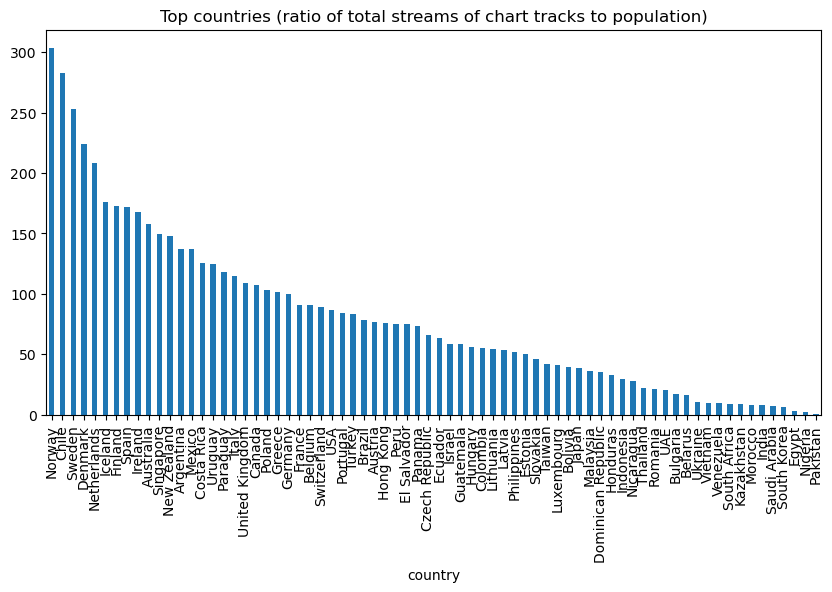

In [26]:
population_and_streams.set_index('country').streams_vs_pop.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title=f'Top countries (ratio of total streams of chart tracks to population)')

This ratio between total Spotify streams and total population for a given country might not be the best metric for 'popularity', but it does produce interesting insights. 

We notice that the ratio of Spotify streams (compared to the total population) is biggest in Norway. The number is also quite big for Sweden (Spotify's 'country of origin') and Denmark. The popularity of Spotify in Chile is certainly surprising.

### Estimating 'financially most relevant' markets

Of course, smaller markets (like Austria with only around 9 mio. total population) are much less relevant for Spotify's income stream compared to bigger countries (like the US with its more than 300 mio. inhabitants). So, let's try to find a metric for measuring 'financial importance' of a particular market/country.

Let's assume that the total number of streams of Top 200 tracks also correlates with the overall popularity of Spotify for any given country.

Then, we can just use the ratio of total streams and population for each country that we already calculated above and multiply it with the population of each country. If we assume that more streams also means more money for Spotify, this would give us a rough idea of the relevance of this country for Spotify.

In [29]:
population_and_streams['financial_importance'] = population_and_streams.streams_vs_pop * population_and_streams.population
population_and_streams.financial_importance = population_and_streams.financial_importance / population_and_streams.financial_importance.max()

<Axes: title={'center': "Top countries by 'financial importance' (ratio of total streams of chart tracks to population * population, normalized by max)"}, xlabel='country'>

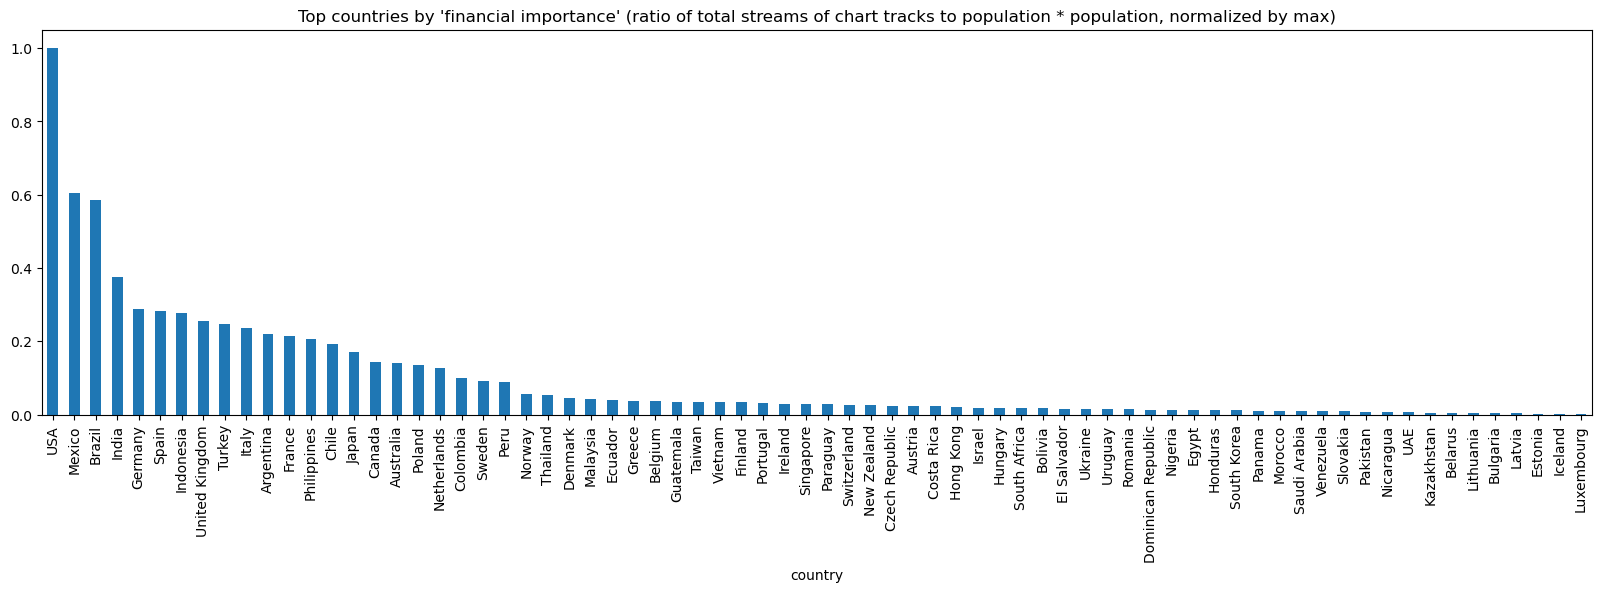

In [39]:
population_and_streams.set_index("country").financial_importance.sort_values(
    ascending=False
).plot(
    kind="bar",
    figsize=(20, 5),
    title=f"Top countries by 'financial importance' (ratio of total streams of chart tracks to population * population, normalized by max)",
)

Here, the US again appear highly relevant! There's one more caveat though: some countries (like India) have significantly lower GDP compared to first world countries. So, this metric is far from perfect.